# Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
assert(len(X_train) == len(y_train))
X_valid, y_valid = valid['features'], valid['labels']
assert(len(X_valid) == len(y_valid))
X_test, y_test = test['features'], test['labels']
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration


In [2]:
import numpy as np
import csv

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# The shape of an traffic sign image
image_shape = X_train[0].shape

# Unique classes/labels there are in the dataset
n_classes = np.unique(y_train).shape[0]

labels = []

# List all the traffic signs from the csv file
with open('signnames.csv', 'r') as csvfile:
    readfile = csv.reader(csvfile, delimiter=',')
    for i in readfile:
        labels += [i[1]]
    labels.pop(0)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

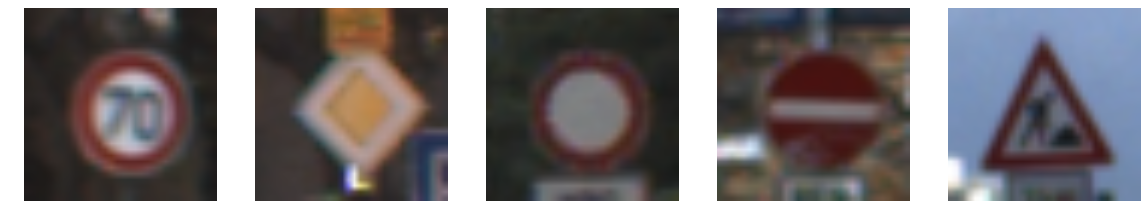

In [3]:
### Data exploration visualization 
import matplotlib.pyplot as plt
import random

%matplotlib inline

figure, axis = plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    index = random.randint(0, len(X_train))
    axis[i].axis('off')
    axis[i].imshow(X_train[index])

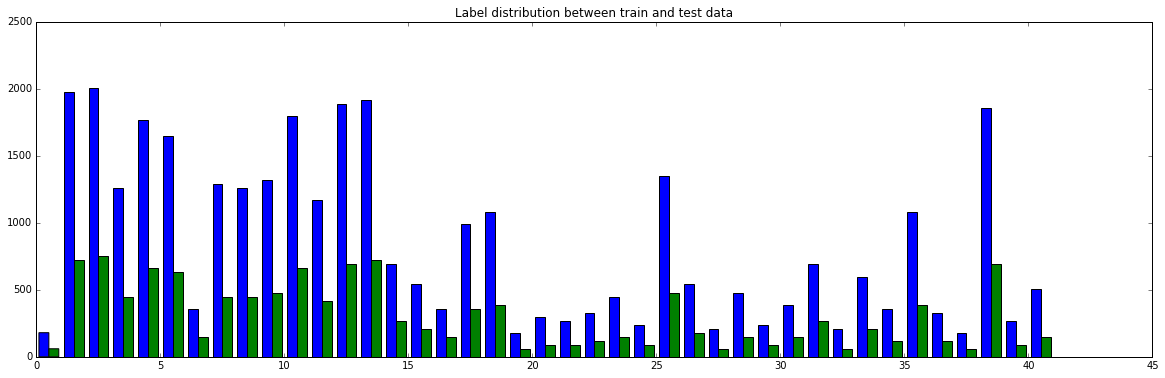

In [4]:
%matplotlib inline

# size of the figure
plt.figure()  
plt.figure(figsize = (20, 6))

# bin from 0 to 42 for 43 classes
bin_list = [x for x in range(0,42)]

# histogram to indicate label distribution in training and testing data
plt.hist([y_train,y_test], bins=bin_list ,histtype = 'bar', rwidth = 0.8)
plt.title('Label distribution between train and test data')
plt.show()

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

In [5]:
import cv2
from sklearn.utils import shuffle

# Convert images in dataset from BGR to Grayscale
def rgb2gray(imgs):
    gray = []
    for i in imgs:
        img = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img, 2)
        gray.append(img)
    return np.array(gray)

In [6]:
# Normalize immages in dataset
def normalize(imgs):
    imgs = imgs.astype('float32')
    imgs = (imgs - 128.) / 128.
    return imgs

In [7]:
# Preprocess function which also includes shuffling data
def preprocess(X, Y):
    #X = rgb2gray(X)
    X = normalize(X)
    X, Y = shuffle(X, Y)
    return X, Y

In [8]:
# Provide data to the preprocessing function
X_train, y_train = preprocess(X_train, y_train)
X_valid, y_valid = preprocess(X_valid, y_valid)
X_test, y_test = preprocess(X_test, y_test)

# Visualize the shape of the training,  validation and test data
print("Preprocessed training data shape", X_train.shape)
print("Preprocessed validation data shape", X_valid.shape)
print("Preprocessed test data shape", X_test.shape)

Preprocessed training data shape (34799, 32, 32, 3)
Preprocessed validation data shape (4410, 32, 32, 3)
Preprocessed test data shape (12630, 32, 32, 3)


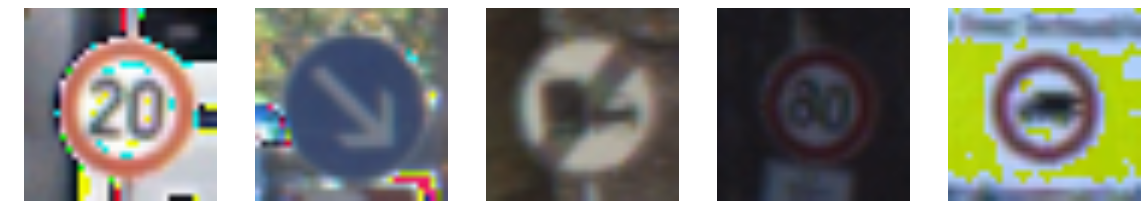

In [9]:
# Randomly select images from the training data and use subplot to visualize them after preprocessing
%matplotlib inline
figure, axis = plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    index = random.randint(0, len(X_train))
    axis[i].axis('off')
    axis[i].imshow(X_train[index])

### Model Architecture

In [10]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='conv1')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='conv2')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [11]:
# Placeholders and one hot encoded labels
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [12]:
# Training pipeline
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [13]:
# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

In [14]:
# Training and Validation
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.732

EPOCH 2 ...
Validation Accuracy = 0.828

EPOCH 3 ...
Validation Accuracy = 0.870

EPOCH 4 ...
Validation Accuracy = 0.879

EPOCH 5 ...
Validation Accuracy = 0.873

EPOCH 6 ...
Validation Accuracy = 0.902

EPOCH 7 ...
Validation Accuracy = 0.899

EPOCH 8 ...
Validation Accuracy = 0.906

EPOCH 9 ...
Validation Accuracy = 0.907

EPOCH 10 ...
Validation Accuracy = 0.906

EPOCH 11 ...
Validation Accuracy = 0.914

EPOCH 12 ...
Validation Accuracy = 0.894

EPOCH 13 ...
Validation Accuracy = 0.910

EPOCH 14 ...
Validation Accuracy = 0.929

EPOCH 15 ...
Validation Accuracy = 0.915

EPOCH 16 ...
Validation Accuracy = 0.914

EPOCH 17 ...
Validation Accuracy = 0.924

EPOCH 18 ...
Validation Accuracy = 0.912

EPOCH 19 ...
Validation Accuracy = 0.918

EPOCH 20 ...
Validation Accuracy = 0.916

EPOCH 21 ...
Validation Accuracy = 0.901

EPOCH 22 ...
Validation Accuracy = 0.927

EPOCH 23 ...
Validation Accuracy = 0.931

EPOCH 24 ...
Validation Accura

In [15]:
# Evaluation on Test data
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.946


---

## Step 3: Test a Model on New Images


### Load and Output the Images

(275, 275, 3)
(250, 250, 3)
(250, 284, 3)
(250, 250, 3)
(120, 120, 3)
(32, 32, 3)


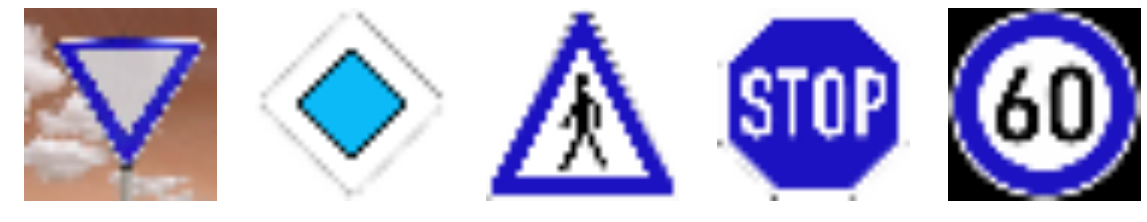

In [16]:
%matplotlib inline
import os
import matplotlib.image as mpimg

# Read images from sample_images folder
dirpath = os.getcwd()
sample_im = os.listdir("sample_images/")
sample_images = []
for im in sample_im:
    # Read an image
    image = cv2.imread(dirpath+"/sample_images/"+im)
    print(image.shape)
    # Resize the image
    image = cv2.resize(image, (32, 32))
    # Append to list of images
    sample_images.append(image)
sample_images = np.array(sample_images)

# Use subplot and display all images
figure, axis = plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    ima = sample_images[i]
    axis[i].axis('off')
    axis[i].imshow(ima)
    
print(image.shape)

### Predict the Sign Type for Each Image

Preprocessed training data shape (5, 32, 32, 3)
INFO:tensorflow:Restoring parameters from ./lenet


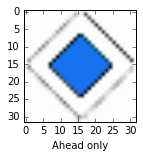

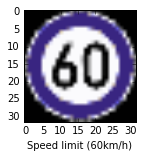

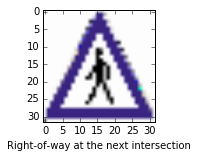

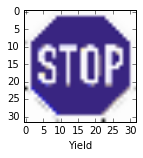

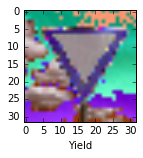

In [17]:
%matplotlib inline
# labels of the corresponding sample_images
sample_labels = [13, 12, 27, 14, 3]

# Preprocess the sample_images and display shape
sample_images, sample_labels = preprocess(sample_images, sample_labels)
print("Preprocessed training data shape", sample_images.shape)

# Run the model on the sample_images
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred_logits = sess.run(logits, feed_dict={x: sample_images})
    pred_labels = np.argmax(pred_logits, axis=1)
    # Display the images and the corresponding predicted label
    for i in range(len(sample_im)):
        figure, axis = plt.subplots(1,1, figsize=(5, 2))
        axis.imshow(sample_images[i])
        axis.set_xlabel(labels[pred_labels[i]])

### Analyze Performance

In [18]:
### the accuracy for these 5 new images. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(sample_images, sample_labels)
    print("Test Accuracy = {:.0f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 40%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./lenet


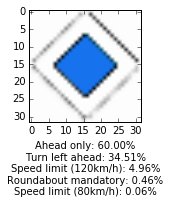

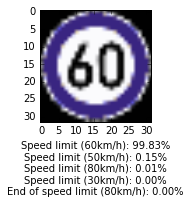

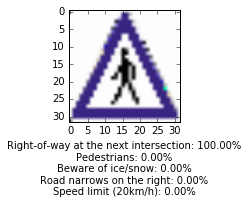

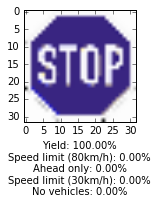

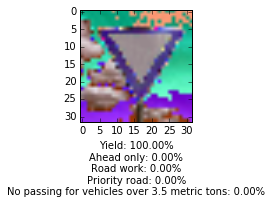

In [19]:
### the top five softmax probabilities
%matplotlib inline
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax = tf.nn.softmax(pred_logits)
    top5soft = sess.run(tf.nn.top_k(softmax, k=5))
    for i in range(len(sample_im)):
        figure, axis = plt.subplots(1,1, figsize=(5, 2))
        axis.imshow(sample_images[i])
        string = ''
        for j in range(5):
            string += '%s: %.2f%%\n' % (labels[top5soft[1][i][j]].replace('\n', ''), top5soft[0][i][j]*100)
        axis.set_xlabel(string)